# ``Delay`` Protocol

## Introduction

Delays are fundamental in neural systems, arising from:
- **Axonal conduction delays**: Signal propagation along axons takes time
- **Synaptic delays**: Chemical transmission across synapses introduces latency
- **Network delays**: Multi-step information processing creates temporal lags

BrainState provides three powerful APIs for handling delays:

1. **`brainstate.nn.Delay`**: General-purpose delay buffer for any data
2. **`brainstate.nn.DelayAccess`**: Named accessor for specific delay entries
3. **`brainstate.nn.StateWithDelay`**: Automatic delay tracking for module states

### Learning Objectives

By the end of this tutorial, you will:

- ✅ Understand the two delay buffer methods: rotation vs concatenation
- ✅ Use `Delay` to create flexible delay buffers with multiple delay taps
- ✅ Access delayed values using `DelayAccess` and named entries
- ✅ Leverage `StateWithDelay` for automatic state history tracking
- ✅ Implement realistic neural models with synaptic and axonal delays
- ✅ Choose between step-based and time-based delay retrieval
- ✅ Use linear vs round interpolation for continuous-time delays

---

## Setup

In [1]:
import brainstate
import brainunit as u
import jax.numpy as jnp
import matplotlib.pyplot as plt

brainstate.environ.set(dt=0.1 * u.ms)  # 0.1 ms time step

---

## Part 1: Understanding `brainstate.nn.Delay`

### 1.1 What is a Delay Buffer?

A delay buffer stores a **rolling history** of values over time. Think of it as a time window looking into the past:

```
Time:  t-3    t-2    t-1    t (now)
       │      │      │      │
Data:  [10] → [20] → [30] → [40]
       ↑      ↑      ↑      ↑
     delay=3 delay=2 delay=1 delay=0
```

The `Delay` class maintains this history efficiently using two methods:

1. **Rotation method** (default): Uses a ring buffer with modulo indexing
2. **Concatenation method**: Shifts data by concatenating new values

### 1.2 Creating a Basic Delay

Let's create a simple delay buffer for a scalar signal:

In [2]:
# Create a delay buffer for a scalar value
# We need to specify the shape/dtype of data we'll store
target_data = jnp.array([0.0])  # Example: scalar in array form

# Create delay with 5ms maximum delay
delay_buffer = brainstate.nn.Delay(
    target_info=target_data,  # Shape/dtype template
    time=5.0 * u.ms,          # Maximum delay time
    init=0.0,                 # Initial history value
    delay_method='rotation'   # Use ring buffer (default)
)

# Initialize the state
delay_buffer.init_state()

print(f"Maximum delay time: {delay_buffer.max_time}")
print(f"Maximum delay length (steps): {delay_buffer.max_length}")
print(f"History buffer shape: {delay_buffer.history.value.shape}")

Maximum delay time: 5.0 * msecond
Maximum delay length (steps): 51
History buffer shape: (51, 1)


### 1.3 Registering Delay Entries

You can register **multiple named entries** for different delay times:

In [3]:
# Create delay buffer with multiple taps
delay_buffer = brainstate.nn.Delay(
    target_info=jnp.array([0.0]),
    time=10.0 * u.ms,  # Support delays up to 10ms
    init=0.0
)

# Register different delay times with names
delay_buffer.register_entry('immediate', 0.0 * u.ms)   # No delay
delay_buffer.register_entry('short', 2.0 * u.ms)       # 2ms delay
delay_buffer.register_entry('medium', 5.0 * u.ms)      # 5ms delay
delay_buffer.register_entry('long', 10.0 * u.ms)       # 10ms delay

delay_buffer.init_state()

print("Registered delay entries:")
for name, delay_info in delay_buffer._registered_entries.items():
    print(f"  {name}: {delay_info} steps")

Registered delay entries:
  immediate: (Array(0, dtype=int32),) steps
  short: (Array(20, dtype=int32),) steps
  medium: (Array(50, dtype=int32),) steps
  long: (Array(100, dtype=int32),) steps


### 1.4 Updating and Accessing Delayed Values

Now let's simulate a signal and access its delayed versions:

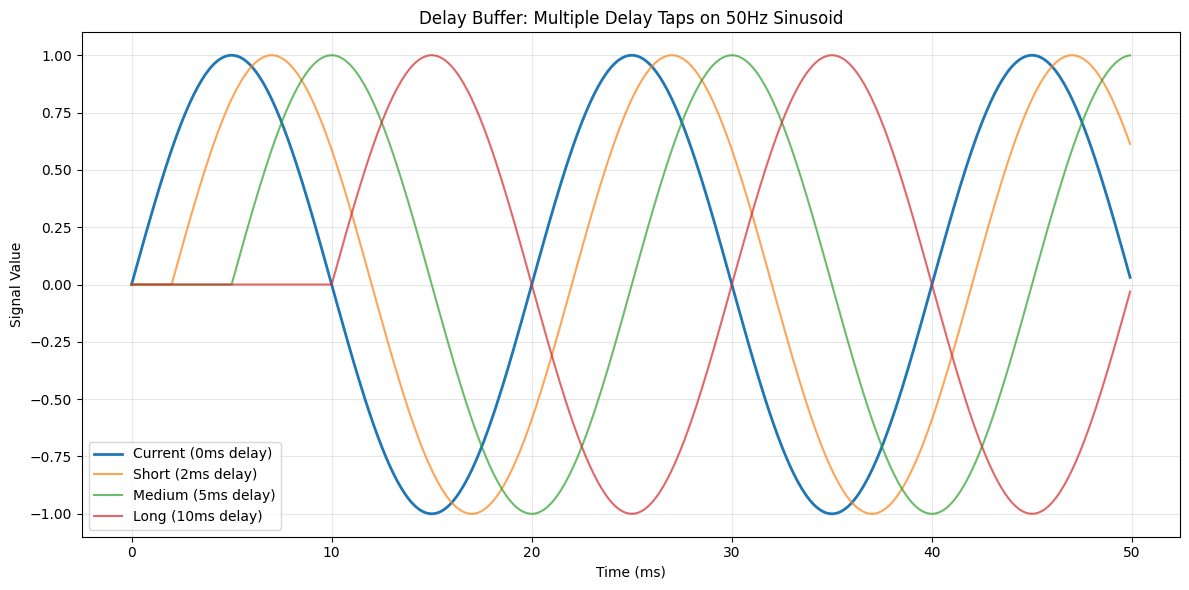

✅ Delay buffer successfully stores and retrieves delayed values


In [4]:
# Simulation parameters
duration = 50.0 * u.ms
dt = brainstate.environ.get_dt()
num_steps = int(duration / dt)

# Storage for visualization
times = []
current_values = []
delayed_short = []
delayed_medium = []
delayed_long = []

# Simulate a sinusoidal signal
for i in range(num_steps):
    t = i * dt
    brainstate.environ.set(i=i, t=t)
    
    # Current signal: sin(2π * 50Hz * t)
    current = jnp.sin(2 * jnp.pi * 50.0 * (t / u.second)) 
    current_array = jnp.array([current])
    
    # Update delay buffer with current value
    delay_buffer.update(current_array)
    
    # Retrieve delayed values
    val_immediate = delay_buffer.at('immediate')[0]
    val_short = delay_buffer.at('short')[0]
    val_medium = delay_buffer.at('medium')[0]
    val_long = delay_buffer.at('long')[0]
    
    # Store for plotting
    times.append(float(t / u.ms))
    current_values.append(float(val_immediate))
    delayed_short.append(float(val_short))
    delayed_medium.append(float(val_medium))
    delayed_long.append(float(val_long))

# Visualize
plt.figure(figsize=(12, 6))
plt.plot(times, current_values, label='Current (0ms delay)', linewidth=2)
plt.plot(times, delayed_short, label='Short (2ms delay)', alpha=0.7)
plt.plot(times, delayed_medium, label='Medium (5ms delay)', alpha=0.7)
plt.plot(times, delayed_long, label='Long (10ms delay)', alpha=0.7)
plt.xlabel('Time (ms)')
plt.ylabel('Signal Value')
plt.title('Delay Buffer: Multiple Delay Taps on 50Hz Sinusoid')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ Delay buffer successfully stores and retrieves delayed values")

### 1.5 Rotation vs Concatenation Methods

**Rotation method** (ring buffer):
- More memory efficient
- Uses modulo indexing: `index = (current_step - delay_step) % max_length`
- Default and recommended for most cases

**Concatenation method**:
- Shifts entire buffer on each update
- Easier to understand conceptually
- Can be slower for large buffers

Let's compare both:

In [5]:
# Create two delay buffers with different methods
delay_rotation = brainstate.nn.Delay(
    target_info=jnp.array([0.0]),
    time=5.0 * u.ms,
    delay_method='rotation'
)
delay_rotation.register_entry('test', 3.0 * u.ms)
delay_rotation.init_state()

delay_concat = brainstate.nn.Delay(
    target_info=jnp.array([0.0]),
    time=5.0 * u.ms,
    delay_method='concat'
)
delay_concat.register_entry('test', 3.0 * u.ms)
delay_concat.init_state()

# Simulate 10 steps
print("Comparing rotation vs concatenation methods:\n")
for i in range(10):
    brainstate.environ.set(i=i)
    
    # Update both with same value
    value = jnp.array([float(i)])
    delay_rotation.update(value)
    delay_concat.update(value)
    
    # Retrieve delayed values
    val_rotation = delay_rotation.at('test')[0]
    val_concat = delay_concat.at('test')[0]
    
    print(f"Step {i}: Rotation={val_rotation:.1f}, Concat={val_concat:.1f}, Match={jnp.allclose(val_rotation, val_concat)}")

print("\n✅ Both methods produce identical results")

Comparing rotation vs concatenation methods:

Step 0: Rotation=0.0, Concat=0.0, Match=True
Step 1: Rotation=0.0, Concat=0.0, Match=True
Step 2: Rotation=0.0, Concat=0.0, Match=True
Step 3: Rotation=0.0, Concat=0.0, Match=True
Step 4: Rotation=0.0, Concat=0.0, Match=True
Step 5: Rotation=0.0, Concat=0.0, Match=True
Step 6: Rotation=0.0, Concat=0.0, Match=True
Step 7: Rotation=0.0, Concat=0.0, Match=True
Step 8: Rotation=0.0, Concat=0.0, Match=True
Step 9: Rotation=0.0, Concat=0.0, Match=True

✅ Both methods produce identical results


---

## Part 2: Time-based vs Step-based Retrieval

### 2.1 Step-based Retrieval

When you know the exact delay in **integer time steps**, use `retrieve_at_step()`:

In [6]:
delay_buffer = brainstate.nn.Delay(
    target_info=jnp.array([0.0]),
    time=10.0 * u.ms,
)
delay_buffer.init_state()

# Populate buffer
for i in range(20):
    brainstate.environ.set(i=i)
    delay_buffer.update(jnp.array([float(i * 10)]))

# Retrieve by step (integer delay)
brainstate.environ.set(i=19)  # At step 19
current = delay_buffer.retrieve_at_step(0)      # 0 steps back
delayed_5 = delay_buffer.retrieve_at_step(5)    # 5 steps back
delayed_10 = delay_buffer.retrieve_at_step(10)  # 10 steps back

print("Step-based retrieval at step 19:")
print(f"  0 steps back (current):  {current[0]:.1f} (expected: {19*10})")
print(f"  5 steps back:            {delayed_5[0]:.1f} (expected: {(19-5)*10})")
print(f"  10 steps back:           {delayed_10[0]:.1f} (expected: {(19-10)*10})")

Step-based retrieval at step 19:
  0 steps back (current):  190.0 (expected: 190)
  5 steps back:            140.0 (expected: 140)
  10 steps back:           90.0 (expected: 90)


### 2.2 Time-based Retrieval

When delays are specified in **continuous time**, use `retrieve_at_time()`. This supports interpolation:

In [7]:
# Create delay with linear interpolation
delay_linear = brainstate.nn.Delay(
    target_info=jnp.array([0.0]),
    time=5.0 * u.ms,
    interp_method='linear_interp'  # Linear interpolation
)
delay_linear.init_state()

# Create delay with round interpolation
delay_round = brainstate.nn.Delay(
    target_info=jnp.array([0.0]),
    time=5.0 * u.ms,
    interp_method='round'  # Round to nearest step
)
delay_round.init_state()

# Populate both buffers
for i in range(100):
    t = i * brainstate.environ.get_dt()
    brainstate.environ.set(i=i, t=t)
    value = jnp.array([float(i)])
    delay_linear.update(value)
    delay_round.update(value)

# Retrieve at non-integer delay times
t_current = 99 * brainstate.environ.get_dt()
brainstate.environ.set(i=99, t=t_current)

delay_time = 2.5 * u.ms  # 2.5ms = 25 steps (non-integer at 0.1ms resolution)
target_time = t_current - delay_time

val_linear = delay_linear.retrieve_at_time(target_time)[0]
val_round = delay_round.retrieve_at_time(target_time)[0]

print(f"Time-based retrieval at t={float(t_current / u.ms):.1f}ms, delay={float(delay_time / u.ms)}ms:")
print(f"  Linear interpolation: {val_linear:.2f} (between steps 74 and 75)")
print(f"  Round interpolation:  {val_round:.2f} (rounds to nearest step)")
print(f"  Expected exact value: {99 - 25} (25 steps back from step 99)")

Time-based retrieval at t=9.9ms, delay=2.5ms:
  Linear interpolation: 74.00 (between steps 74 and 75)
  Round interpolation:  74.00 (rounds to nearest step)
  Expected exact value: 74 (25 steps back from step 99)


### 2.3 Interpolation Comparison

Let's visualize the difference between linear and round interpolation:

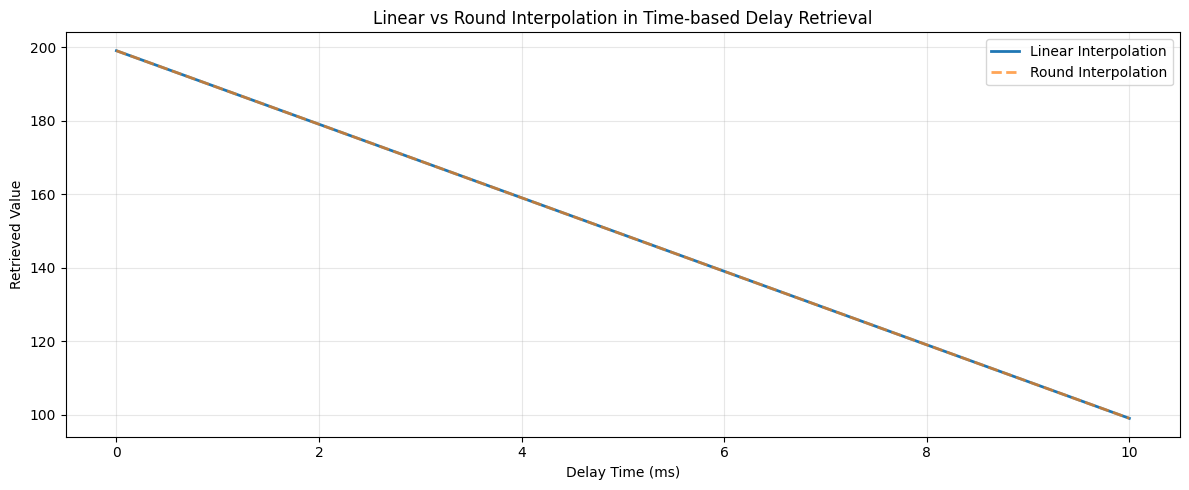

✅ Linear interpolation provides smooth continuous values
✅ Round interpolation snaps to nearest discrete time step


In [8]:
# Create delays with different interpolation
delay_linear = brainstate.nn.Delay(jnp.array([0.0]), time=10.0 * u.ms, interp_method='linear_interp')
delay_round = brainstate.nn.Delay(jnp.array([0.0]), time=10.0 * u.ms, interp_method='round')
delay_linear.init_state()
delay_round.init_state()

# Populate with ramp signal
for i in range(200):
    t = i * brainstate.environ.get_dt()
    brainstate.environ.set(i=i, t=t)
    value = jnp.array([float(i)])
    delay_linear.update(value)
    delay_round.update(value)

# Test various delay times (non-integer steps)
t_now = 199 * brainstate.environ.get_dt()
brainstate.environ.set(i=199, t=t_now)

delay_times_ms = jnp.linspace(0.0, 10.0, 101)  # 0 to 10ms
linear_vals = []
round_vals = []

for delay_ms in delay_times_ms:
    delay_time = delay_ms * u.ms
    target_time = t_now - delay_time
    
    val_linear = delay_linear.retrieve_at_time(target_time)[0]
    val_round = delay_round.retrieve_at_time(target_time)[0]
    
    linear_vals.append(float(val_linear))
    round_vals.append(float(val_round))

plt.figure(figsize=(12, 5))
plt.plot(delay_times_ms, linear_vals, label='Linear Interpolation', linewidth=2)
plt.plot(delay_times_ms, round_vals, label='Round Interpolation', linewidth=2, alpha=0.7, linestyle='--')
plt.xlabel('Delay Time (ms)')
plt.ylabel('Retrieved Value')
plt.title('Linear vs Round Interpolation in Time-based Delay Retrieval')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ Linear interpolation provides smooth continuous values")
print("✅ Round interpolation snaps to nearest discrete time step")

---

## Part 3: `brainstate.nn.DelayAccess`

### 3.1 What is DelayAccess?

`DelayAccess` creates a **reusable accessor** for a specific delay entry. It's useful when:
- You need to pass delay accessors to other modules
- You want to encapsulate delay configuration
- Building modular neural network components

### 3.2 Creating and Using DelayAccess

In [9]:
# Create a delay buffer
delay_buffer = brainstate.nn.Delay(
    target_info=jnp.array([0.0, 0.0, 0.0]),  # 3D vector
    time=10.0 * u.ms,
)
delay_buffer.init_state()

# Create DelayAccess objects for different delays
# Method 1: Using .access() method
accessor_2ms = delay_buffer.access('entry_2ms', 2.0 * u.ms)
accessor_5ms = delay_buffer.access('entry_5ms', 5.0 * u.ms)

# Simulate signal
for i in range(200):
    brainstate.environ.set(i=i)
    
    # Update with [i, i*2, i*3]
    value = jnp.array([float(i), float(i*2), float(i*3)])
    delay_buffer.update(value)

# Access delayed values through DelayAccess objects
delayed_2ms = accessor_2ms.update()  # Call update() to retrieve
delayed_5ms = accessor_5ms.update()

print("DelayAccess retrieval at step 199:")
print(f"  2ms delay (20 steps): {delayed_2ms}")
print(f"  5ms delay (50 steps): {delayed_5ms}")
print(f"  Expected 2ms: [{199-20}, {(199-20)*2}, {(199-20)*3}]")
print(f"  Expected 5ms: [{199-50}, {(199-50)*2}, {(199-50)*3}]")

DelayAccess retrieval at step 199:
  2ms delay (20 steps): [179. 358. 537.]
  5ms delay (50 steps): [149. 298. 447.]
  Expected 2ms: [179, 358, 537]
  Expected 5ms: [149, 298, 447]


### 3.3 Using DelayAccess in Modules

DelayAccess is particularly useful when building modular components:

In [10]:
class DelayedConnection(brainstate.nn.Module):
    """A module that applies delayed weighted connection."""
    
    def __init__(self, size, weight, delay_time):
        super().__init__()
        self.weight = weight
        
        # Create delay buffer and accessor
        self.delay_buffer = brainstate.nn.Delay(
            target_info=jnp.zeros(size),
            time=delay_time * 2,  # Buffer size
        )
        self.delay_access = self.delay_buffer.access('conn', delay_time)
    
    def update(self, current_input):
        # Store current input
        self.delay_buffer.update(current_input)
        
        # Get delayed input
        delayed_input = self.delay_access.update()
        
        # Apply weight to delayed input
        return self.weight * delayed_input

# Create delayed connection
conn = DelayedConnection(size=5, weight=0.5, delay_time=3.0 * u.ms)
conn.delay_buffer.init_state()

# Simulate
print("Testing DelayedConnection module:\n")
for i in range(50):
    brainstate.environ.set(i=i)
    
    # Input: [i, i, i, i, i]
    input_signal = jnp.ones(5) * i
    output = conn.update(input_signal)
    
    if i % 10 == 0:
        print(f"Step {i:2d}: Input={float(input_signal[0]):5.1f}, Output={float(output[0]):5.1f}")

print("\n✅ DelayAccess enables modular delay handling in custom modules")

Testing DelayedConnection module:

Step  0: Input=  0.0, Output=  0.0
Step 10: Input= 10.0, Output=  0.0
Step 20: Input= 20.0, Output=  0.0
Step 30: Input= 30.0, Output=  0.0
Step 40: Input= 40.0, Output=  5.0

✅ DelayAccess enables modular delay handling in custom modules


---

## Part 4: `brainstate.nn.StateWithDelay`

### 4.1 What is StateWithDelay?

`StateWithDelay` is a **specialized delay** that automatically tracks a `State` variable in a module:

- Automatically bound to a module's state (e.g., membrane potential `V`)
- Updates history buffer after each simulation step
- Commonly created via `prefetch_delay()` helper
- Ideal for delayed feedback and recurrent connections

### 4.2 Using StateWithDelay via `prefetch_delay()`

The easiest way to use `StateWithDelay` is through the Dynamics `prefetch_delay()` method:

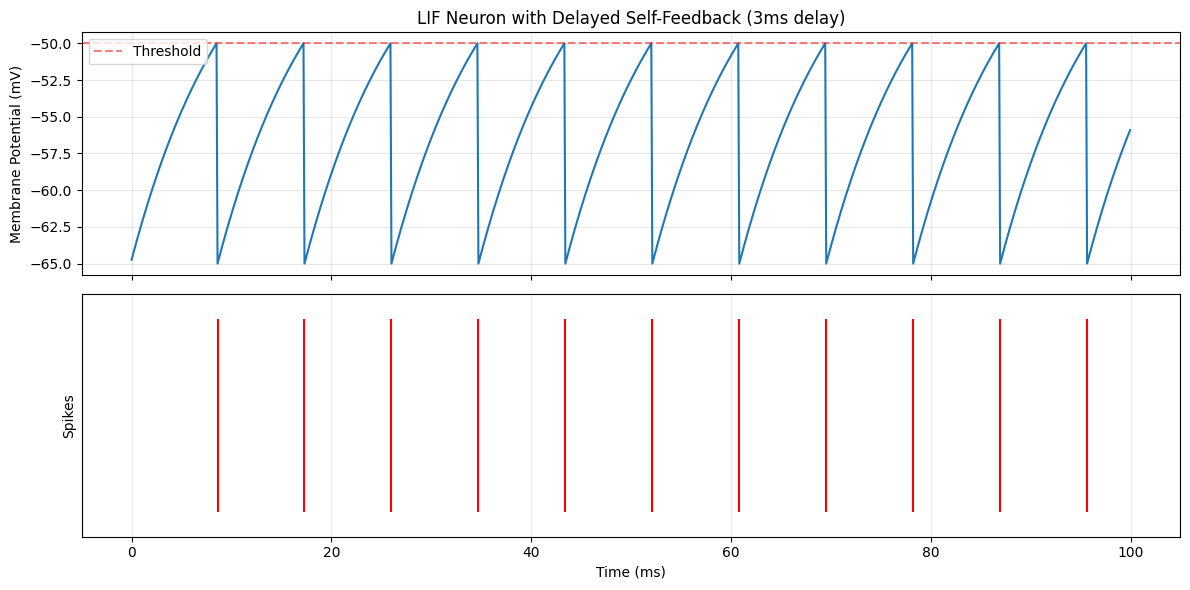

✅ StateWithDelay automatically tracks module states for delayed feedback


In [13]:
class LIFWithDelayedFeedback(brainstate.nn.Dynamics):
    """LIF neuron with delayed self-feedback."""
    
    def __init__(self, size, feedback_delay=5.0 * u.ms, feedback_strength=0.3):
        super().__init__(in_size=size)
        
        # Neuron parameters
        self.tau = 10.0 * u.ms
        self.V_rest = -65.0 * u.mV
        self.V_th = -50.0 * u.mV
        self.V_reset = -65.0 * u.mV
        self.R = 1.0 * u.ohm
        self.feedback_strength = feedback_strength
        
        # States
        self.V = brainstate.State(jnp.ones(size) * self.V_rest)
        self.spike = brainstate.State(jnp.zeros(size, dtype=bool))
        
        # Create StateWithDelay for V using prefetch_delay()
        # This automatically creates a StateWithDelay and registers it
        self.V_delayed = self.prefetch_delay('V', feedback_delay)
    
    def update(self, I):
        # Get delayed voltage for feedback
        V_delayed = self.V_delayed()  # Call to retrieve delayed value
        
        # Add delayed feedback to input current
        feedback_current = (V_delayed - self.V_rest) * self.feedback_strength / self.R
        I_total = I + feedback_current
        
        # Update voltage (exponential Euler)
        dt = brainstate.environ.get_dt()
        alpha = jnp.exp(-dt / self.tau)
        V_inf = self.V_rest + I_total * self.R
        self.V.value = self.V.value * alpha + V_inf * (1 - alpha)
        
        # Spike detection and reset
        self.spike.value = self.V.value >= self.V_th
        self.V.value = u.math.where(self.spike.value, self.V_reset, self.V.value)
        
        return self.spike.value

# Create neuron with delayed feedback
neuron = LIFWithDelayedFeedback(size=1, feedback_delay=3.0 * u.ms, feedback_strength=0.4)
brainstate.nn.init_all_states(neuron)

# Simulate
duration = 100.0 * u.ms
num_steps = int(duration / brainstate.environ.get_dt())

times = []
voltages = []
spikes = []

for i in range(num_steps):
    t = i * brainstate.environ.get_dt()
    brainstate.environ.set(i=i, t=t)
    
    # Constant input current
    I_input = 1.5 * u.nA * jnp.ones(1)
    
    spike_output = neuron.update(I_input)
    
    times.append(float(t / u.ms))
    voltages.append(float(neuron.V.value[0] / u.mV))
    spikes.append(float(spike_output[0]))

# Visualize
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Voltage trace
ax1.plot(times, voltages, linewidth=1.5)
ax1.axhline(y=-50.0, color='r', linestyle='--', alpha=0.5, label='Threshold')
ax1.set_ylabel('Membrane Potential (mV)')
ax1.set_title('LIF Neuron with Delayed Self-Feedback (3ms delay)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Spike raster
spike_times = [times[i] for i in range(len(spikes)) if spikes[i] > 0.5]
ax2.eventplot([spike_times], lineoffsets=0.5, linelengths=0.8, colors='red')
ax2.set_ylabel('Spikes')
ax2.set_xlabel('Time (ms)')
ax2.set_ylim([0, 1])
ax2.set_yticks([])
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ StateWithDelay automatically tracks module states for delayed feedback")

### 4.3 Direct StateWithDelay Creation

You can also create `StateWithDelay` explicitly (advanced usage):

In [14]:
class SimpleNeuron(brainstate.nn.Dynamics):
    """Simple neuron for demonstration."""
    
    def __init__(self, size):
        super().__init__(in_size=size)
        self.V = brainstate.State(jnp.zeros(size))
    
    def update(self, x):
        self.V.value = self.V.value * 0.9 + x
        return self.V.value

# Create neuron
neuron = SimpleNeuron(size=3)
neuron.init_state()

# Manually create StateWithDelay for neuron.V
state_delay = brainstate.nn.StateWithDelay(
    target=neuron,          # The module owning the state
    item='V',               # Name of the state attribute
    delay_method='rotation'
)

# Register a delay time
state_delay.register_entry('V_5ms', 5.0 * u.ms)

# Initialize
state_delay.init_state()

# Simulate
print("Manual StateWithDelay creation:\n")
for i in range(100):
    brainstate.environ.set(i=i)
    
    # Update neuron
    neuron.update(jnp.array([1.0, 2.0, 3.0]) * (i / 10.0))
    
    # Update delay buffer (must be done manually in this case)
    state_delay.update()
    
    if i % 20 == 0:
        current_V = neuron.V.value
        delayed_V = state_delay.at('V_5ms')
        print(f"Step {i:3d}: Current V={current_V}, Delayed V={delayed_V}")

print("\n✅ StateWithDelay can be created explicitly for fine-grained control")

Manual StateWithDelay creation:

Step   0: Current V=[0. 0. 0.], Delayed V=[0. 0. 0.]
Step  20: Current V=[12.094189 24.188377 36.282566], Delayed V=[0. 0. 0.]
Step  40: Current V=[31.133022 62.266045 93.39906 ], Delayed V=[0. 0. 0.]
Step  60: Current V=[ 51.016167 102.03233  153.0485  ], Delayed V=[ 4.1381054  8.276211  12.414316 ]
Step  80: Current V=[ 71.00195 142.0039  213.00584], Delayed V=[21.381517 42.763035 64.14455 ]

✅ StateWithDelay can be created explicitly for fine-grained control


---

## Part 5: Practical Example - Synaptic Transmission with Delays

Let's build a realistic synapse model with axonal and dendritic delays:

### 5.1 Delayed Synaptic Connection

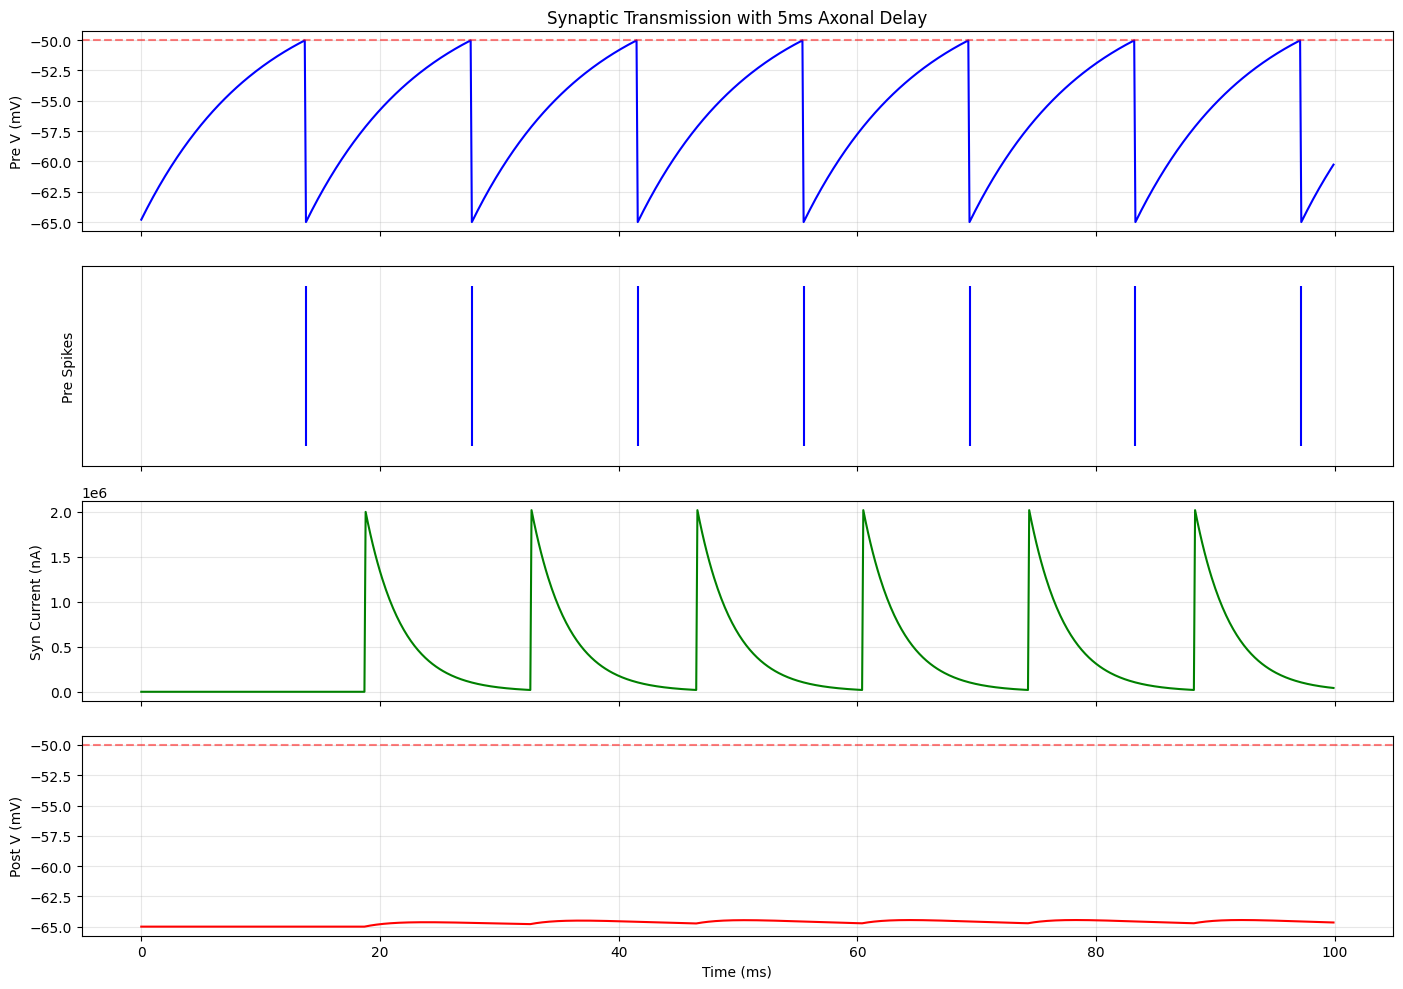


✅ Delayed synaptic transmission: presynaptic spikes appear at postsynaptic neuron after 5ms delay
   First pre spike: ~13.8ms
   First syn current rise: ~18.8ms (5ms delay)


In [19]:
class SimpleLIF(brainstate.nn.Dynamics):
    """Simple LIF neuron."""
    
    def __init__(self, size, tau=10.0 * u.ms, V_rest=-65.0 * u.mV,
                 V_th=-50.0 * u.mV, V_reset=-65.0 * u.mV, R=1.0 * u.ohm):
        super().__init__(in_size=size)
        
        self.tau = tau
        self.V_rest = V_rest
        self.V_th = V_th
        self.V_reset = V_reset
        self.R = R
        
        self.V = brainstate.State(jnp.ones(size) * V_rest)
        self.spike = brainstate.State(jnp.zeros(size, dtype=bool))
    
    def update(self, I):
        dt = brainstate.environ.get_dt()
        alpha = jnp.exp(-dt / self.tau)
        
        V_inf = self.V_rest + I * self.R
        self.V.value = self.V.value * alpha + V_inf * (1 - alpha)
        
        self.spike.value = self.V.value >= self.V_th
        self.V.value = u.math.where(self.spike.value, self.V_reset, self.V.value)
        
        return self.spike.value


class DelayedSynapse(brainstate.nn.Dynamics):
    """Synapse with conduction delay."""
    
    def __init__(self, pre_size, post_size, weight_matrix, 
                 axonal_delay=2.0 * u.ms, tau_syn=5.0 * u.ms):
        super().__init__(in_size=pre_size)
        
        self.weight = weight_matrix
        self.tau_syn = tau_syn
        
        # Synaptic current state
        self.I_syn = brainstate.State(jnp.zeros(post_size) * u.mA)
        
        # Create delay buffer for presynaptic spikes
        self.spike_delay = brainstate.nn.Delay(
            target_info=jnp.zeros(pre_size, dtype=bool),
            time=axonal_delay * 2,
            init=False
        )
        self.spike_delay.register_entry('axonal', axonal_delay)
    
    def update(self, pre_spike):
        # Store presynaptic spikes
        self.spike_delay.update(pre_spike)
        
        # Retrieve delayed spikes
        delayed_spike = self.spike_delay.at('axonal')
        
        # Synaptic current injection
        I_input = self.weight @ delayed_spike.astype(jnp.float32)
        
        # Synaptic current decay
        dt = brainstate.environ.get_dt()
        alpha = jnp.exp(-dt / self.tau_syn)
        self.I_syn.value = self.I_syn.value * alpha + I_input
        
        return self.I_syn.value


# Create network: pre -> synapse -> post
pre_neuron = SimpleLIF(size=1)
post_neuron = SimpleLIF(size=1)

# Synaptic weight
weight = jnp.array([[2.0]]) * u.mA  # Strong connection

synapse = DelayedSynapse(
    pre_size=1, 
    post_size=1, 
    weight_matrix=weight,
    axonal_delay=5.0 * u.ms,  # 5ms axonal delay
    tau_syn=3.0 * u.ms
)

# Initialize
pre_neuron.init_state()
post_neuron.init_state()
synapse.spike_delay.init_state()

# Simulate
duration = 100.0 * u.ms
num_steps = int(duration / brainstate.environ.get_dt())

times = []
pre_voltages = []
post_voltages = []
syn_currents = []
pre_spikes = []
post_spikes = []

for i in range(num_steps):
    t = i * brainstate.environ.get_dt()
    brainstate.environ.set(i=i, t=t)
    
    # Strong input to presynaptic neuron
    I_pre = 20. * u.mA * jnp.ones(1)
    
    # Update presynaptic neuron
    pre_spike = pre_neuron.update(I_pre)
    
    # Update synapse with delayed transmission
    I_syn = synapse.update(pre_spike)
    
    # Update postsynaptic neuron
    post_spike = post_neuron.update(I_syn)
    
    # Record
    times.append(float(t / u.ms))
    pre_voltages.append(float(pre_neuron.V.value[0] / u.mV))
    post_voltages.append(float(post_neuron.V.value[0] / u.mV))
    syn_currents.append(float(I_syn[0] / u.nA))
    pre_spikes.append(float(pre_spike[0]))
    post_spikes.append(float(post_spike[0]))

# Visualize
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# Presynaptic voltage
axes[0].plot(times, pre_voltages, 'b', linewidth=1.5)
axes[0].axhline(y=-50.0, color='r', linestyle='--', alpha=0.5)
axes[0].set_ylabel('Pre V (mV)')
axes[0].set_title('Synaptic Transmission with 5ms Axonal Delay')
axes[0].grid(True, alpha=0.3)

# Presynaptic spikes
pre_spike_times = [times[i] for i in range(len(pre_spikes)) if pre_spikes[i] > 0.5]
axes[1].eventplot([pre_spike_times], lineoffsets=0.5, linelengths=0.8, colors='blue')
axes[1].set_ylabel('Pre Spikes')
axes[1].set_ylim([0, 1])
axes[1].set_yticks([])
axes[1].grid(True, alpha=0.3)

# Synaptic current
axes[2].plot(times, syn_currents, 'g', linewidth=1.5)
axes[2].set_ylabel('Syn Current (nA)')
axes[2].grid(True, alpha=0.3)

# Postsynaptic voltage
axes[3].plot(times, post_voltages, 'r', linewidth=1.5)
axes[3].axhline(y=-50.0, color='r', linestyle='--', alpha=0.5)
axes[3].set_ylabel('Post V (mV)')
axes[3].set_xlabel('Time (ms)')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Delayed synaptic transmission: presynaptic spikes appear at postsynaptic neuron after 5ms delay")
if len(pre_spike_times) > 0:
    print(f"   First pre spike: ~{pre_spike_times[0]:.1f}ms")
    print(f"   First syn current rise: ~{pre_spike_times[0] + 5.0:.1f}ms (5ms delay)")

---

## Part 6: Advanced - Heterogeneous Delays

### 6.1 Vector Delays

BrainState supports **heterogeneous delays** where each element can have a different delay time:

In [20]:
# Create delay buffer for 3 neurons
delay_buffer = brainstate.nn.Delay(
    target_info=jnp.zeros(3),
    time=10.0 * u.ms,
)

# Register heterogeneous delays: different delay for each neuron
# Delays: [2ms, 5ms, 8ms]
delay_times = jnp.array([2.0, 5.0, 8.0]) * u.ms
neuron_indices = jnp.array([0, 1, 2])  # Which neuron

delay_buffer.register_entry('heterogeneous', delay_times, neuron_indices)
delay_buffer.init_state()

# Simulate
for i in range(200):
    brainstate.environ.set(i=i)
    
    # Update with [i, i*10, i*100]
    values = jnp.array([float(i), float(i*10), float(i*100)])
    delay_buffer.update(values)

# Retrieve heterogeneous delays
delayed_values = delay_buffer.at('heterogeneous')

expected_delays_steps = jnp.array([20, 50, 80])  # in steps (0.1ms each)
expected_values = jnp.array([
    199 - 20,
    (199 - 50) * 10,
    (199 - 80) * 100
])

print("Heterogeneous delays at step 199:")
print(f"  Delays: [2ms, 5ms, 8ms] = {expected_delays_steps} steps")
print(f"  Retrieved values: {delayed_values}")
print(f"  Expected values:  {expected_values}")
print(f"  Match: {jnp.allclose(delayed_values, expected_values)}")

print("\n✅ Vector delays enable different delay times for each element")

Heterogeneous delays at step 199:
  Delays: s, 5ms, 8ms] = [20 50 80] steps
  Retrieved values: [  179.  1490. 11900.]
  Expected values:  [  179  1490 11900]
  Match: True

✅ Vector delays enable different delay times for each element


---

## Summary

### Key Concepts

1. **`brainstate.nn.Delay`**: General-purpose delay buffer
   - Stores rolling history of values
   - Supports rotation (ring buffer) or concatenation methods
   - Multiple named delay entries via `register_entry()`
   - Step-based (`retrieve_at_step`) or time-based (`retrieve_at_time`) retrieval
   - Linear or round interpolation for continuous-time queries

2. **`brainstate.nn.DelayAccess`**: Named accessor for delay entries
   - Created via `delay.access(entry, delay_time)`
   - Encapsulates delay configuration
   - Useful for modular design
   - Call `.update()` to retrieve delayed value

3. **`brainstate.nn.StateWithDelay`**: Automatic state tracking
   - Bound to a module's `State` variable
   - Created via `prefetch_delay(state_name, delay_time)`
   - Automatically updates after each step
   - Ideal for delayed feedback and recurrent connections
   - Call as function `()` to retrieve delayed state

### API Comparison Table

| Feature | `Delay` | `DelayAccess` | `StateWithDelay` |
|---------|---------|---------------|------------------|
| **Use Case** | General data buffering | Named accessors | Module state tracking |
| **Creation** | Manual instantiation | Via `delay.access()` | Via `prefetch_delay()` |
| **Updates** | Manual `update(value)` | Inherits from Delay | Automatic after step |
| **Retrieval** | `at(entry)` or `retrieve_at_*` | `.update()` | Call as function `()` |
| **Multiple delays** | ✅ Multiple entries | ✅ One per accessor | ✅ Multiple registrations |
| **Interpolation** | ✅ Linear or round | ✅ Via underlying Delay | ✅ Via underlying Delay |

### Best Practices

1. **Choose the right tool**:
   - Use `Delay` for general data buffering (synaptic inputs, external signals)
   - Use `DelayAccess` when passing delay accessors to other modules
   - Use `StateWithDelay` (via `prefetch_delay()`) for module state feedback

2. **Delay method selection**:
   - Default to `rotation` (ring buffer) for efficiency
   - Use `concat` only if you need sequential buffer structure

3. **Interpolation**:
   - Use `linear_interp` for smooth continuous-time delays
   - Use `round` for discrete time steps

4. **Buffer sizing**:
   - Set `time` parameter larger than maximum expected delay
   - Buffer size = `ceil(max_delay / dt) + 1` steps

5. **Initialization**:
   - Always call `.init_state()` before simulation
   - Provide meaningful `init` values for t < 0 history

### Common Patterns

**Pattern 1: Delayed synaptic connection**
```python
# In synapse __init__:
self.spike_delay = brainstate.nn.Delay(jnp.zeros(pre_size), time=delay_time)
self.spike_delay.register_entry('syn', delay_time)

# In synapse update:
self.spike_delay.update(pre_spike)
delayed_spike = self.spike_delay.at('syn')
```

**Pattern 2: Delayed feedback**
```python
# In neuron __init__:
self.V_delayed = self.prefetch_delay('V', feedback_delay)

# In neuron update:
V_past = self.V_delayed()
feedback = compute_feedback(V_past)
```

**Pattern 3: Multiple delay taps**
```python
delay = brainstate.nn.Delay(data, time=max_delay)
delay.register_entry('short', 2.0 * u.ms)
delay.register_entry('medium', 5.0 * u.ms)
delay.register_entry('long', 10.0 * u.ms)
```

---

## Exercise

**Challenge**: Implement a network of 3 LIF neurons with the following connections:
- Neuron 0 → Neuron 1 (2ms delay, weight=1.0)
- Neuron 1 → Neuron 2 (5ms delay, weight=1.5)
- Neuron 2 → Neuron 0 (3ms delay, weight=-0.5, inhibitory)

Use `brainstate.nn.Delay` for the synaptic connections and simulate for 200ms.

**Hints**:
1. Create 3 `SimpleLIF` neurons
2. Create 3 `DelayedSynapse` objects for the connections
3. Drive Neuron 0 with external input
4. Plot voltage traces of all 3 neurons
5. Observe the sequential activation with delays

---

## What's Next?

- **Tutorial 7: Collective Operations** - Learn about communication patterns in neural populations
- **Advanced Delays** - Explore plastic delays and state-dependent delays
- **Network Architecture** - Build large-scale networks with distributed delays

---

**Congratulations!** You now understand BrainState's powerful delay mechanisms for modeling realistic neural dynamics. 🎉